In [1]:
import sys 
sys.path.insert(0,'../')

%matplotlib inline
from scripts.Deblender import Deblend
from scripts.utils import listdir_fullpath
from scripts.utils import norm, denorm

import numpy as np
import os

import matplotlib.pyplot as plt

bands = [4,5,6,7,8,9]

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

2022-02-24 10:57:18.690940: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/fvae_miniconda/lib/:
2022-02-24 10:57:18.690997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 18
max_number = 3
batch_size = 1
max_shift = 2
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("Rubin")
seed=17

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [3]:
def crop_image(image, pos, cutout_size):
    """
    crops a portion of the image.
    
    Parameters
    ----------
    image:
    
    pos:
    
    cutout_size: float
        cutout size in arcminutes
    
    Returns
    -------
    cropped image
    """
    
    cutout_pixel_size = int(cutout_size * 5)
    
    y_crop_start = round(pos[0] - (cutout_pixel_size-1)/2)
    y_crop_end = round(pos[0] + (cutout_pixel_size-1)/2)
    
    x_crop_start = round(pos[1] - (cutout_pixel_size-1)/2)
    x_crop_end = round(pos[1] + (cutout_pixel_size-1)/2)
    
    #print(np.shape(image))
    #print(pos)
    #print(x_crop_start)
    #print(x_crop_end+1)
    cropped_image = image[2, x_crop_start:x_crop_end+1, y_crop_start:y_crop_end+1]
    
    #print(np.shape(crop_image))
    return cropped_image.copy()


In [4]:
blend = next(draw_generator)


blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])



(6, 90, 90)

In [11]:
print("input_image)
plt.imshow(blend['blend_images'][0, 2])

NameError: name 'input_image' is not defined

In [6]:
detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i]])

print(detected_positions)
deb = Deblend(blend['blend_images'][0]/80000, detected_positions, num_components=len(blend['blend_list'][0]), use_likelihood=True)


[[45.539401852601976, 42.44483267670603], [42.12543895022813, 43.2069609838386], [39.36895534407477, 46.50417595273592]]


2022-02-24 10:57:32.268041: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/fvae_miniconda/lib/:
2022-02-24 10:57:32.268114: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-24 10:57:32.268163: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-02-24 10:57:32.268831: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-0

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])

2022-02-24 10:57:35.866264: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f674e6ac0d0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f674cbf3550>).
(90, 90, 6)
Some galaxies are too close from the border of the field to be considered here.
sigma :0.0052416474
log prob flow:4188.789
reconstruction loss34026.73
tf.Tensor(29837.941, shape=(), dtype=float32)
sigma :0.005495487
log prob flow:4185.2725
reconstruction loss53423.56
tf.Tensor(49238.285, shape=(), dtype=float32)
sigma :0.005131945
log prob flow:4186.539
reconstruction loss42388.62
tf.Tensor(38202.082, shape=(), dtype=float32)
sigma :0.0050832517
log prob flow:4189.599
reconstruction loss47739.445
tf.Tensor(43549.848, shape=(), dtype=float32)
sigma :0.005127653
log prob flow:4188.583
reconstruction loss49556.16
tf.Tensor(45367.58, shape=(), dtype=float32)
sigma :0.005107449
log prob flow:4192.322
reconstruction loss48323.97
tf.Tensor(

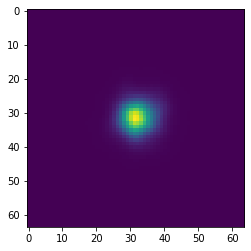

In [7]:
plt.imshow(deb.components[0][:, :, 2])

0
1
2


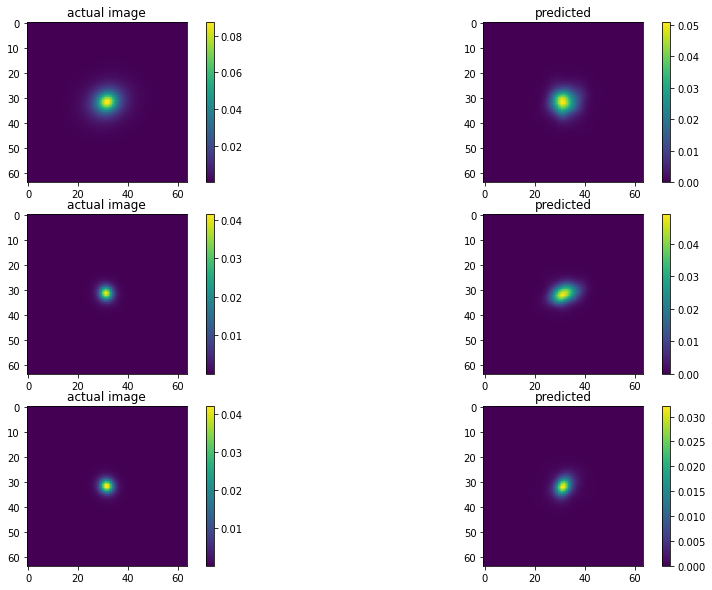

In [8]:
fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(15,10*len(blend['blend_list'])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    print(i)
    im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i]/80000, detected_positions[i], 12.8))
    fig.colorbar(im1, ax=ax[i, 0])
    ax[i, 0].set_title("actual image")

    im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
    fig.colorbar(im2, ax=ax[i, 1])
    ax[i, 1].set_title("predicted")
    
plt.show()



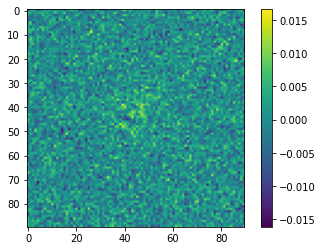

In [9]:
fig = plt.figure()
ax = fig.gca()
residual = deb.compute_residual()
im1 = ax.imshow(residual[:, :, 2])
fig.colorbar(im1, ax=ax)
